# Time Series Analysis

*A time series is a series of data points indexed (or listed or graphed) in time order* (Wikipedia). 

Our goal as quantitative researchers is to identify trends, seasonal variations and correlation using statistical time series methods, and ultimately generate trading signals or filters based on inference or predictions. In order to improve the profitability of our trading models, we must make use of statistical techniques to identify consistent behaviour in assets which can be exploited to turn a profit. To find this behaviour we must explore how the properties of the asset prices themselves change in time.

Time Series Analysis helps us to achieve this. **It provides us with a robust statistical framework for assessing the behaviour of time series, such as asset prices, in order to help us trade off of this behaviour.**


This is the first of a series of posts which will cover basic concepts related to statistical modeling of time series and various time series forecasting techniques.


## Time Series Analysis - Part 1: Stationarity, Autocorrelation and White Noise

In this post, we will talk about two important concepts in time series analysis - Staionarity and Correlation. We recommend going through the math workbooks on [Expected Value](https://github.com/Auquan/Tutorials/blob/master/Expected%20Value%20and%20Standard%20Deviation.ipynb)
, Variance and Correlation before this workbook.

In [81]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [82]:
import auquanToolbox.dataloader as dl

end = '2015-01-01'
start = '2007-01-01'
symbols = ['SPX','DOW','MSFT']
data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Reading SPX
Reading DOW
Reading MSFT


## Stationarity

Stationarity is an extremely important aspect of time series -  much of the analysis carried out on financial time series data involves identifying if the series we want to predict is stationary, and if it is not,findingys to transform it such that it is stationary. 

*Mean of a time series $x_t$ is $E(x_t)=\mu(t)$*

*Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$*

**A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time**

**A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time**

This image from SEANABU.COM should help 

![Courtsey: SEANABU.COM ](download.png)

### Why do we care about stationarity? 

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

## Serial Correlation (Autocorrelation)

Essentially when we model a time series we decompose the series into three components: trend, seasonal/cyclical, and random. 

The random component is called the residual or error - the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other. It tells us how sequential observations in a time series affect each other. If we can find structure in these observations then it will likely help us improve our forecasts and simulation accuracy. This will lead to greater profitability in our trading strategies or better risk management approaches.

Formally, for a covariance-stationary time series (as #3 above, where covariance between sequential observations is not a function of time), autocorrelation $\rho_k$ for lag $k$ (the number of time steps separating two sequantial observations), $$\rho_k = E[(x_t - \mu)(x_t + k - \mu)]/\sigma^2$$

### Why Do We Care about Serial Correlation? 

Serial correlation is critical for the validity of our model predictions, and is intrinsically related to stationarity. Recall that the residuals (errors) of a stationary TS are serially uncorrelated by definition! If we fail to account for this in our models the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True! In layman's terms, ignoring autocorrelation means our model predictions will be bunk, and we're likely to draw incorrect conclusions about the impact of the independent variables in our model. 

## White Noise and Random Walks

With this knowledge, let's discuss our first time series models - White Noise and Random Walks.

By definition *a time series that is a white noise process has serially uncorrelated errors and the expected mean of those errors is equal to zero.* This means that each element of the serially uncorrelated errors is an independent realisation from some probability distribution, i.e it is independent and identically distributed (i.i.d.). 

This is important because, if our time series model is appropriate and successful at capturing the underlying process and explaining the serial correlation, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it.

In [83]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

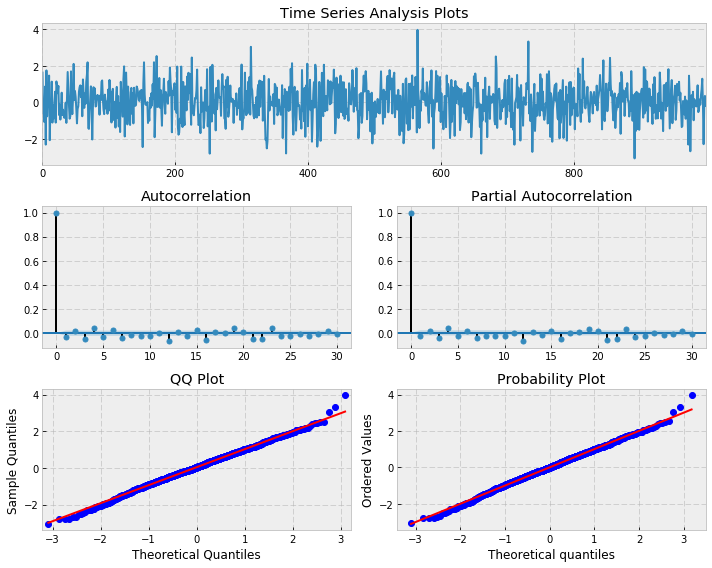

In [84]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We note the following:

* The process appears to be random and centered about zero
* The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation (Remember we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution)
* Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution.

In [85]:
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

## Random Walk

A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step, that is the expected value of current observation is equal to the previous observation. It is formally defined below:

$$x_t=x_{t-1}+w_t$$ , where $w_t$ is a discrete white noise series.
$$E[x_t]=x_{t-1}$$

The significance of a random walk is that it is non-stationary because while the mean of a random walk is still zero, the covariance is actually time-dependent. In particular, the covariance is equal to the variance multiplied by the time. Hence, as time increases, so does the variance.

Put simply, it means If the TS we are modeling is a random walk it is unpredictable, as they are literally random walks.

Let's simulate a random walk 

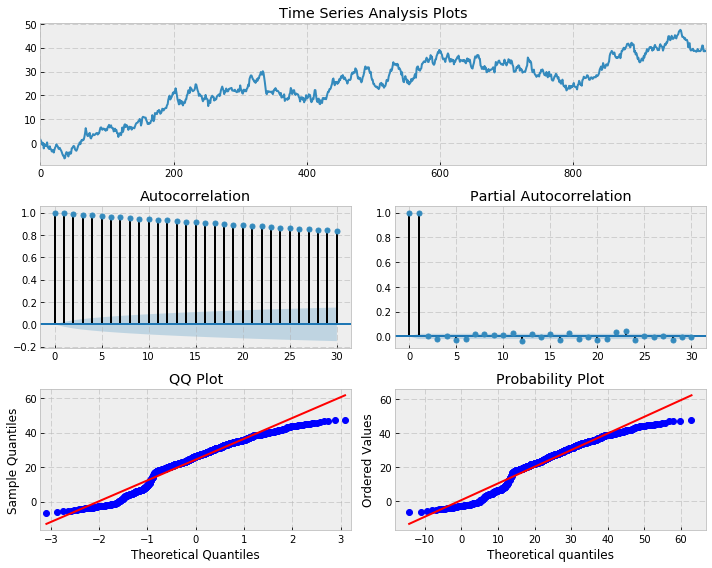

In [86]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. How to check if the random walk model is a good fit for our simulated data? The first differences of our random walk series should equal a white noise process!

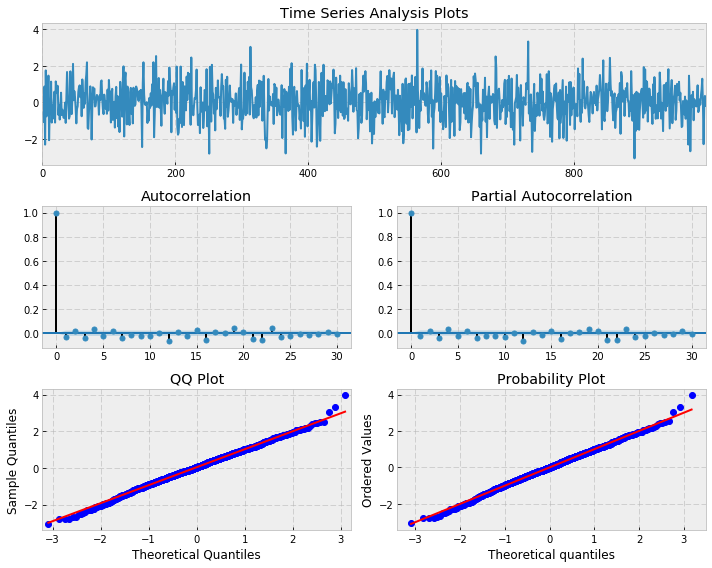

In [87]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

As expected, the difference is indeed white noise.

Let's now apply our random walk model to some actual financial data. 

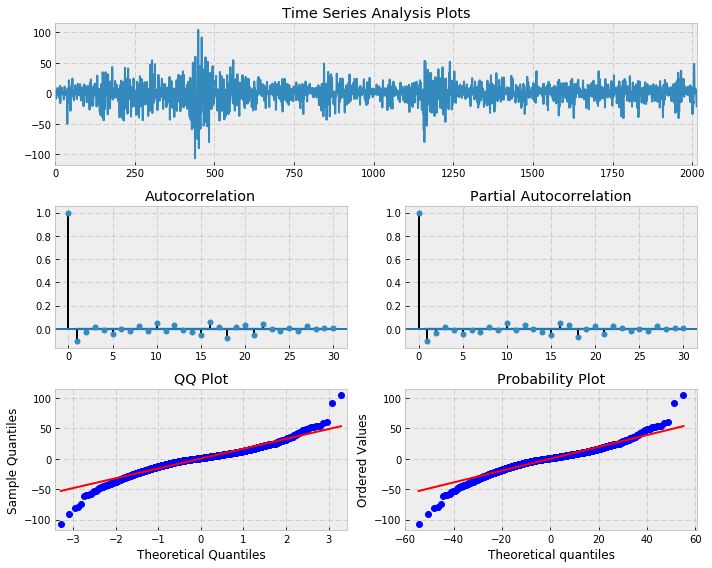

In [88]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPX), lags=30)

It's quite similar to white noise, isn't it? However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5, 15, 18 and 21. This means that there should be better models to describe the actual price change process.

Let's try the same on other equities'

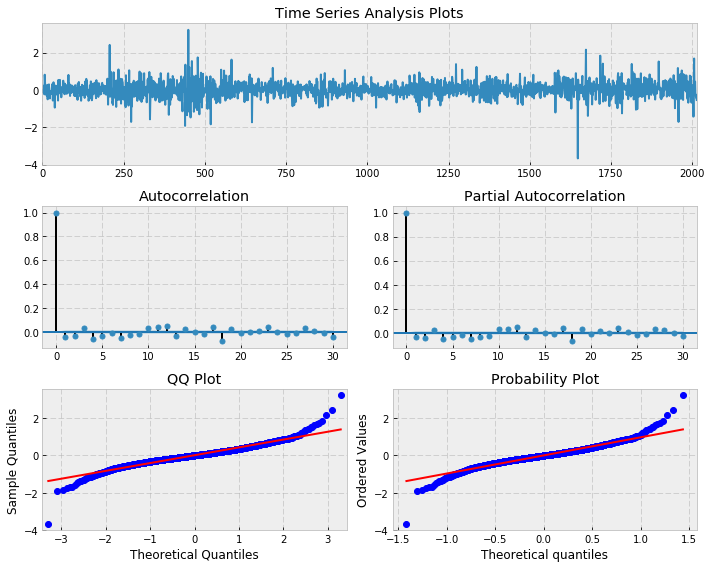

In [89]:
# First difference of MSFT prices
_ = tsplot(np.diff(data.MSFT), lags=30)

Again the time series is quite similar to white noise with similar 'heavy tails' a few peaks in the ACF, and PACF plots.

Before we conclude, let's talk about two more simple TS models.

## Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:
$$x_{t} = a_0+a_1 t + b$$

The value of the time series is determined by the coefficients, $a_0, a_1$ and *time*. An example could be a company's sales that increase by the same amount at each time step. For a hypthtical example, consider a company who's stock price was a 100$ to start, and increase by 50c at every time step. 

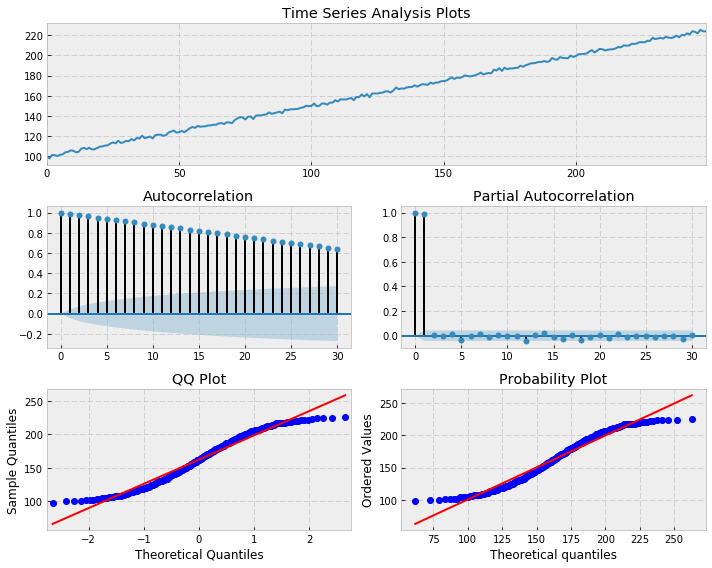

In [90]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)  

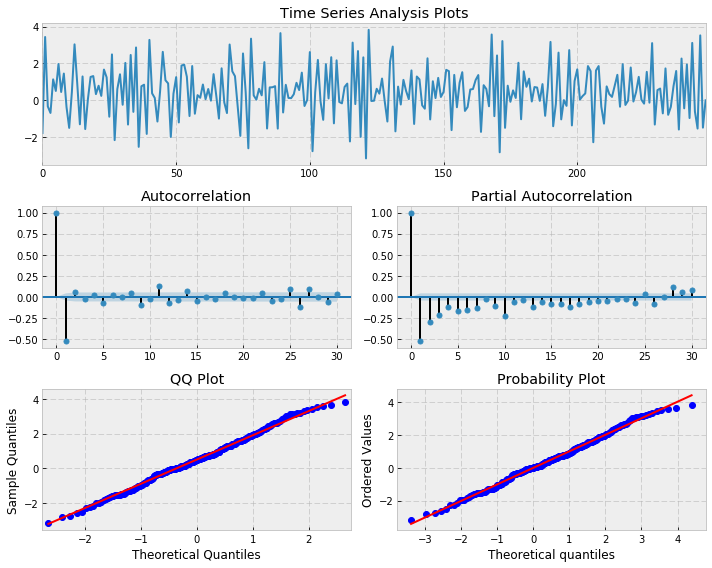

In [91]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)

Here we can see that the residuals of the model are correlated and linearly decreasing as a function of the lag. The distribution is approximately normal. Before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

## Log-Linear Models

Similar to linear models except that the TS that can be graphed using an exponential function. That is the the time series has a constant rate of change with respect to each time step. 
$$x_{t} = exp(a_0+a_1 t)$$
$$log(x_{t}) = a_0+a_1 t$$
$$x_0 = exp(a_0)$$
$$x_t = x_{t-1}*exp(a1)$$
For example, in our above simulated series, if the stock price increased by X% at each time step, you get a curve that looks like this:

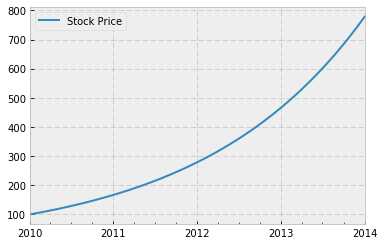

In [92]:
# Simulate exponential growth

idx = pd.date_range('2010-01-01', '2014-01-01', freq='D')
price = [np.exp( 4.605 + float(x)/712 ) for x in range(0, len(idx))]

# create dataframe and plot
df = pd.DataFrame(price, columns=['Stock Price'], index=idx)

with plt.style.context('bmh'):
    df.plot()

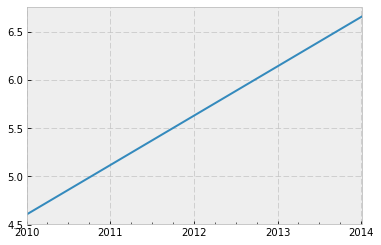

In [93]:
# log of prices

with plt.style.context('bmh'):
    pd.Series(np.log(price), index=idx).plot()

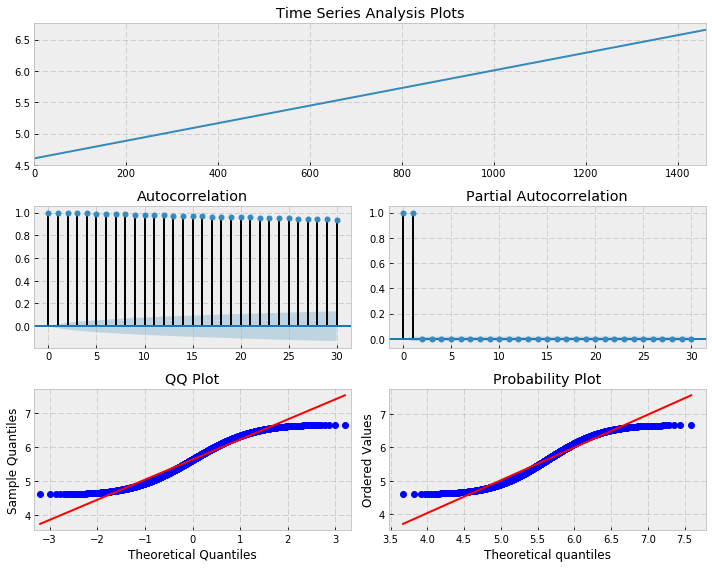

In [94]:
_ = tsplot(np.log(price), lags=30) 

This notebook provides a basic overview of time series analysis. The tests for stationarity, random walk are a common process we will keep visiting in further notebooks. We're next going to talk about more sophisticated time series models.